In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from numpy.fft import fft
import pandas_datareader.data as web
import datetime

/Users/danielmpfeffer/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
# 1984:Q1 to 2015:Q4
start = datetime.datetime(1970, 1, 1)
end = datetime.datetime(2020, 4, 1)

# Quarterly U.S. real GDP from the FRED
ts = web.DataReader(['HOUST', 'COMPUTSA'], 'fred', start, end)
ts = ts.rename(columns={'HOUST':'starts', 'COMPUTSA': 'completions'})

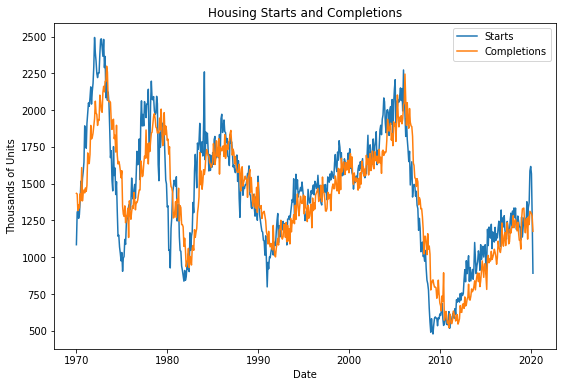

In [4]:
# Plot series
plt.figure(figsize=(9,6))

plt.plot(ts['starts'], label='Starts')
plt.plot(ts['completions'], label='Completions')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.title('Housing Starts and Completions')
plt.legend()

plt.savefig('plot-series')

In [5]:
# Estimate VAR(4)
mod = VAR(ts[:-12][['starts', 'completions']], freq='MS')
res = mod.fit(maxlags=4, trend='n')
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 29, May, 2020
Time:                     20:34:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    17.8786
Nobs:                     588.000    HQIC:                   17.8059
Log likelihood:          -6873.96    FPE:                5.16232e+07
AIC:                      17.7595    Det(Omega_mle):     5.02467e+07
--------------------------------------------------------------------
Results for equation starts
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
L1.starts              0.630744         0.042657           14.786           0.000
L1.completions        -0.001576         0.064064           -0.025           0.980
L2.starts              0.277157         0.049815       

In [6]:
h = 40
starts_acf, completions_acf, starts_ccf, completions_ccf = [], [], [], []
for i in range(h):
    starts_acf.append(res.acorr(h)[i][0][0])
    completions_acf.append(res.acorr(h)[i][1][1])
    starts_ccf.append(res.acorr(h)[i][0][1])
    completions_ccf.append(res.acorr(h)[i][1][0])

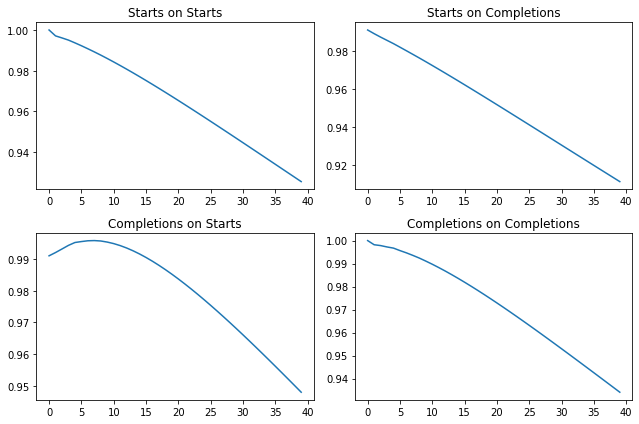

In [15]:
x = list(range(h))

plt.figure(figsize=(9,6))

ax1 = plt.subplot(221)
plt.plot(x, starts_acf)
plt.title('Starts on Starts')

ax2 = plt.subplot(222)
plt.plot(x, starts_ccf)
plt.title('Starts on Completions')


ax3 = plt.subplot(223)
plt.plot(x, completions_ccf)
plt.title('Completions on Starts')

ax4 = plt.subplot(224)
plt.plot(x, completions_acf)
plt.title('Completions on Completions')

plt.tight_layout()
plt.savefig('acf-plots')

In [8]:
starts = ts[:-12]['starts'].values
completions = ts[:-12]['completions'].values

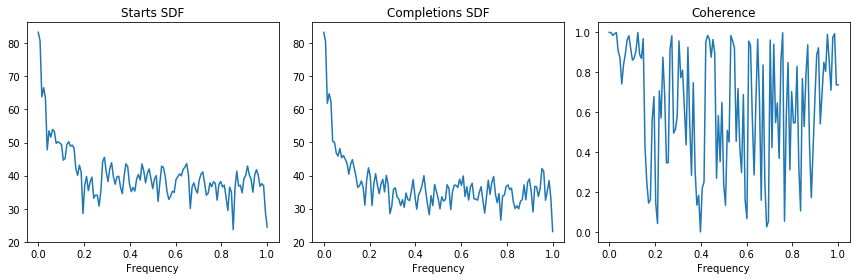

In [9]:
# Plot SDFs
plt.figure(figsize=(12,4))

plt.subplot(131)
plt.psd(starts)
plt.ylabel('')
plt.title('Starts SDF')
plt.grid(False)

plt.subplot(132)
plt.psd(completions)
plt.ylabel('')
plt.title('Completions SDF')
plt.grid(False)

plt.subplot(133)
plt.cohere(starts, completions)
plt.ylabel('')
plt.title('Coherence')
plt.grid(False)

plt.tight_layout()
plt.savefig('sdf')

In [10]:
# Granger causality 
print(res.test_causality('completions', ['starts']).summary())
print(res.test_causality('starts', ['completions']).summary())

Granger causality F-test. H_0: starts does not Granger-cause completions. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         47.34          2.380   0.000 (4, 1160)
-----------------------------------------------
Granger causality F-test. H_0: completions does not Granger-cause starts. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.617          2.380   0.168 (4, 1160)
-----------------------------------------------


In [11]:
irf = res.irf()
res.fevd().summary()

FEVD for starts
       starts  completions
0    1.000000     0.000000
1    0.999999     0.000001
2    0.998405     0.001595
3    0.996939     0.003061
4    0.996697     0.003303
5    0.996013     0.003987
6    0.995139     0.004861
7    0.994288     0.005712
8    0.993548     0.006452
9    0.992784     0.007216

FEVD for completions
       starts  completions
0    0.052131     0.947869
1    0.077790     0.922210
2    0.106267     0.893733
3    0.170836     0.829164
4    0.281572     0.718428
5    0.373584     0.626416
6    0.461076     0.538924
7    0.541396     0.458604
8    0.611799     0.388201
9    0.670018     0.329982




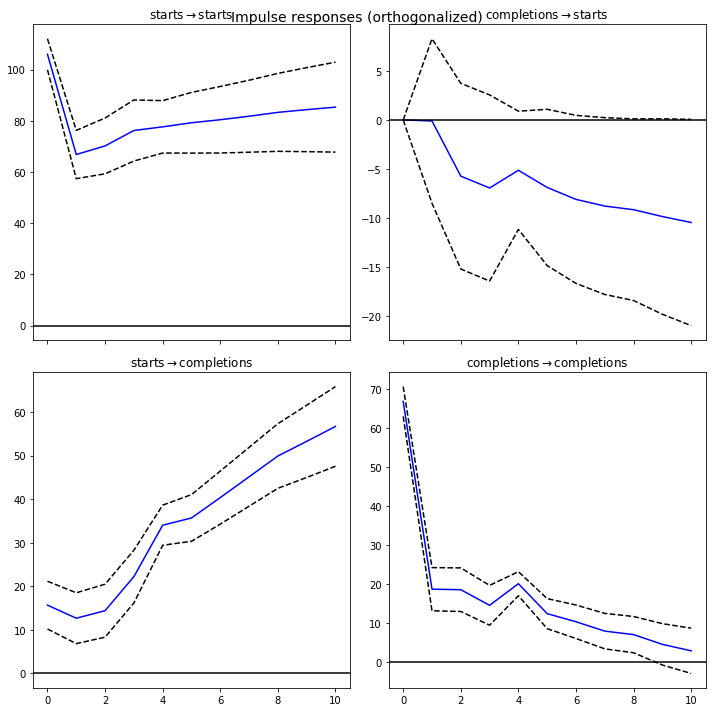

In [12]:
# Plot IRFs
irf.plot(orth=True)
plt.tight_layout()

plt.savefig('irf')

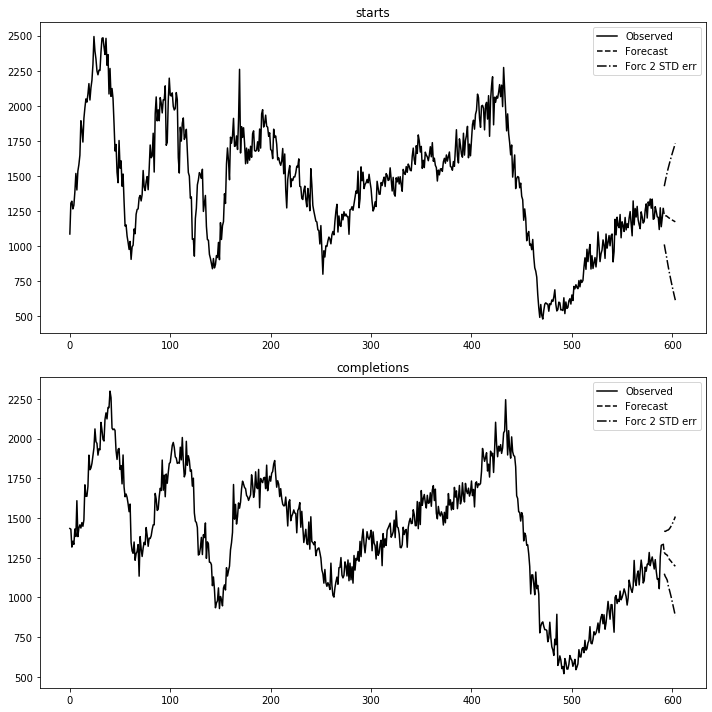

In [13]:
# Plot forecast
res.plot_forecast(steps=12)
plt.tight_layout()

plt.savefig('forecast')